## Pytorch basics:
1. Create tensors of float type and requires_grad = True
2. Perform operations. (All basic matrix operations are elementwise, except matrix multiplication)
3. All intermediaries should be dealt with float tensors with appropriate grad_fn. Some tensors might need to be detached from gradient tracking (grad_fn) using .detach()  
4. The final loss function should be scalar and float tensor with appropriate grad_fn 
5. loss.backward() - use retain_graph = True to call backward() multiple times. Otherwise, the graph is lost
6. use .grad attribute to get gradients
7. Tensors with requires_grad = True can be updated in place using .data attribute (Normal tensors can be updated inplace, but with caution as it can corrupt grad_fn)
8. Pass all parameters to be gradient-updated to the torch.optim (nn.ModuleList, or list)
9. Zero out gradients - optimizer.zero_grad()

**Useful:**
flatten(), squeeze(), reshape(), view(), item(), unsqueeze()

In [1]:
# import the necessary libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device('cuda')

In [150]:
M = 3
P = 3
T = 2000
N = 2000

In [151]:
#@title Default title text
class Posterior(nn.Module):
  def __init__(self, M, P):
    super().__init__()
    self.fc1 = nn.Linear(M, P, bias = False)
    self.activ1 = nn.Tanh()
    self.fc2 = nn.Linear(P, P, bias = False)
    self.activ2 = nn.Sigmoid()
    # self.fc3 = nn.Linear(P, P)
    # self.fc4 = nn.Linear(P, P)

  def forward(self, x):
    x = self.fc1(x)
    # x = self.activ1(x)
    # x = self.fc3(x)
    # x = self.activ1(x)
    # x = self.fc4(x)

    y = torch.eye(P).to(device)
    y = self.fc2(y)
    # y = self.activ2(y)

    return x, torch.matmul(y, y.T) / P # torch.diag(y.flatten())  

class Likelihood(nn.Module):
  def __init__(self, M, P):
    super().__init__()
    self.fc1 = nn.Linear(P, M, bias = False)
    self.activ1 = nn.Tanh()
    self.fc2 = nn.Linear(1, 1, bias = False)
    self.activ2 = nn.Sigmoid()
    # self.fc3 = nn.Linear(M, M)
    # self.fc4 = nn.Linear(M, M)

  def forward(self, x):
    x = self.fc1(x)
    # x = self.activ1(x)
    # x = self.fc3(x)
    # x = self.activ1(x)
    # x = self.fc4(x)

    y = torch.ones((1, 1)).to(device)
    y = self.fc2(y)
    y = self.activ2(y)

    return x, y.squeeze()

class Filter(nn.Module): ## Change for filter
  def __init__(self, P):
    super().__init__()
    self.fc1 = nn.Linear(1, P, bias = False)
    # self.activ_1 = nn.Tanh()
    self.fc2 = nn.Linear(1, P, bias = False)
    self.activ_2 = nn.Sigmoid()

  def forward(self):
    x = torch.ones((1, 1)).to(device)
    b = self.fc1(x)
    b = -0.5 * self.activ_2(b)

    d = self.fc2(x)
    d = -0.5 * self.activ_2(d)
    # d = torch.zeros(1, P) * d 
    return b.T, d.T

In [152]:
#@title Default title text
def get_Hk(b, d): ## Change for filter
  A = (b + (b**2 - 4*d)**0.5) / 2
  B = (b - (b**2 - 4*d)**0.5) / 2
  c1 = A / (A - B)
  c2 = B / (B - A)
  return torch.diag(((c1**2 / (1 - A**2)) + (c2**2 / (1 - B**2)) + (2*c1*c2 / (1 - A*B))).flatten())

def get_Ez(M, P, b, d, mu_posterior): ## Change for filter
  N = mu_posterior.shape[0]
  Ez = torch.zeros(N, P).to(device)
  for k in range(N):
    if k:
      # Ez.data[k:k+1, :] = d.T*Ez.data[k-1:k, :] + mu_posterior[k:k+1,:] + (b - d).T*mu_posterior[k-1:k, :]
      if k > 1:
        Ez.data[k:k+1, :] = mu_posterior[k:k+1,:] + b.T*mu_posterior[k-1:k, :] + d.T*mu_posterior[k-2:k-1, :]
      else:
        Ez.data[k:k+1, :] = mu_posterior[k:k+1,:] + b.T*mu_posterior[k-1:k, :]
    else:
      Ez.data[k:k+1, :] = torch.ones(1, P).to(device) * mu_posterior[k:k+1,:]
  return Ez

def init_latent_loss(sig2_e, mu_posterior, var_posterior):
  Exx_0 = torch.matmul(mu_posterior[0:1, :].T, mu_posterior[0:1, :]) + var_posterior
  return -0.5 * (torch.trace(torch.matmul(torch.diag(1 / torch.diag(sig2_e)), Exx_0)) + torch.sum(torch.log(torch.diag(sig2_e))))

def latent_loss(N, sig2_e, b, d, Ez, var_posterior):
  lambda_d = 1 + torch.matmul(b, b.T) + torch.matmul(d, d.T)  ## Change for filter
  Ezz = torch.matmul(Ez.T, Ez) + ((N - 1) * var_posterior * lambda_d)
  return -0.5 * (torch.trace(torch.matmul(torch.diag(1 / torch.diag(sig2_e)), Ezz)) + (N - 1)*torch.sum(torch.log(torch.diag(sig2_e))))

def reconstruction_loss(N, M, P, Y, likelihood, mu_posterior, var_posterior, B = 50):
  L = 0
  A = torch.linalg.cholesky(var_posterior)
  for i in range(B):
    X = mu_posterior + torch.matmul(torch.randn((N, P)).to(device), A.T)
    Y_hat, sig2_eps = likelihood(X)
    L += torch.trace(torch.matmul(Y - Y_hat, (Y - Y_hat).T))
  return (-L.squeeze() / (2*B*sig2_eps)) - (0.5*M*N*torch.log(sig2_eps))

def entropy_loss(var_posterior):
  l, _ = torch.linalg.eig(var_posterior)
  return 0.5 * torch.sum(torch.log(l)).real # torch.log(torch.det(var_posterior))

def loss(M, P, Y, posterior, likelihood, filter, B = 50):
  N = Y.shape[0]
  mu_posterior, var_posterior = posterior(Y)
  b, d = filter()
  Hk = get_Hk(b, d) # torch.diag((1 + (b**2 / (1 - (d - b)**2))).flatten()) 
  sig2_e = torch.diag(1 / torch.diag(Hk))
  Ez = get_Ez(M, P, b, d, mu_posterior)
  L = init_latent_loss(sig2_e, mu_posterior, var_posterior)
  L += reconstruction_loss(N, M, P, Y, likelihood, mu_posterior, var_posterior, B = B)
  L += latent_loss(N, sig2_e, b, d, Ez, var_posterior)
  L += N * entropy_loss(var_posterior)
  return -L / N

## Model

In [153]:
# likelihood0 = torch.load('likelihood0')
# filter0 = torch.load('filter0')

In [154]:
likelihood0 = Likelihood(M, P)
filter0 = Filter(P)

In [155]:
likelihood0.to(device)
filter0.to(device)

Filter(
  (fc1): Linear(in_features=1, out_features=3, bias=False)
  (fc2): Linear(in_features=1, out_features=3, bias=False)
  (activ_2): Sigmoid()
)

In [156]:
b0, d0 = filter0()
Hk0 = get_Hk(b0, d0) # torch.diag((1 + (b0**2 / (1 - (d0 - b0)**2))).flatten())
sig2_e0 = torch.inverse(Hk0)

## DGP

In [157]:
## Change for filter

Y = torch.zeros(T, M).to(device)
X = torch.zeros(T, P).to(device)
E = torch.zeros(T, P).to(device)

for k in range(T):
  E[k:k+1, :] = torch.matmul(sig2_e0**0.5, torch.randn(P, 1).to(device)).T
  if k:
    if k > 1:
      X.data[k:k+1, :] = -b0.T*X.data[k-1:k, :] - d0.T*X.data[k-2:k-1, :] + E[k:k+1, :]
    else:
      X.data[k:k+1, :] = -b0.T*X.data[k-1:k, :] + E[k:k+1, :] 
  else:
    X.data[k:k+1, :] = torch.ones(1, P).to(device) * E[k:k+1, :]

In [158]:
Y, sig2_eps0 = likelihood0(X)
Y.data += (sig2_eps0**0.5) * torch.randn(T, M).to(device)

In [159]:
Y = Y[-N:, :].detach()
X = X[-N:, :].cpu().detach().numpy()

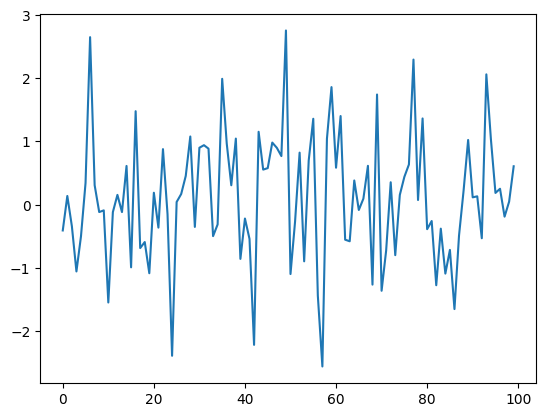

In [160]:
plt.plot(Y.cpu().numpy()[:100, 0])

## Test Data

In [161]:
## Change for filter

Y_test = torch.zeros(T, M).to(device)
X_test = torch.zeros(T, P).to(device)
E_test = torch.zeros(T, P).to(device)

for k in range(T):
  E_test[k:k+1, :] = torch.matmul(sig2_e0**0.5, torch.randn(P, 1).to(device)).T
  if k:
    if k > 1:
      X_test.data[k:k+1, :] = -b0.T*X_test.data[k-1:k, :] - d0.T*X_test.data[k-2:k-1, :] + E_test[k:k+1, :]
    else:
      X_test.data[k:k+1, :] = -b0.T*X_test.data[k-1:k, :] + E_test[k:k+1, :] 
  else:
    X_test.data[k:k+1, :] = torch.ones(1, P).to(device) * E_test[k:k+1, :]

In [162]:
Y_test, sig2_eps0 = likelihood0(X_test)
Y_test.data += (sig2_eps0**0.5) * torch.randn(T, M).to(device)

In [163]:
Y_test = Y_test[-N:, :].detach()
X_test = X_test[-N:, :].cpu().detach().numpy()

## Subspace Identification

In [164]:
posterior = Posterior(M, P)
likelihood = Likelihood(M, P)
filter = Filter(P)

In [165]:
likelihood.to(device)
filter.to(device)
posterior.to(device)

Posterior(
  (fc1): Linear(in_features=3, out_features=3, bias=False)
  (activ1): Tanh()
  (fc2): Linear(in_features=3, out_features=3, bias=False)
  (activ2): Sigmoid()
)

In [166]:
optimizer_1 = torch.optim.Adam(posterior.parameters(), lr = 1e-3)
optimizer_2 = torch.optim.Adam(nn.ModuleList([likelihood, filter]).parameters(), lr = 1e-3)

In [167]:
B = 10
epochs = 100
L = []
iter = 10
for epoch in range(epochs):
  for i in range(iter):
    loss_val = loss(M, P, Y, posterior, likelihood, filter, B = B)
    # L.append(loss_val.item())
    loss_val.backward()
    optimizer_1.step()
    optimizer_1.zero_grad()
  for i in range(iter):
    loss_val = loss(M, P, Y, posterior, likelihood, filter, B = B)
    L.append(loss_val.item())
    loss_val.backward()
    optimizer_2.step()
    optimizer_2.zero_grad()

Text(0.5, 0, 'iterations')

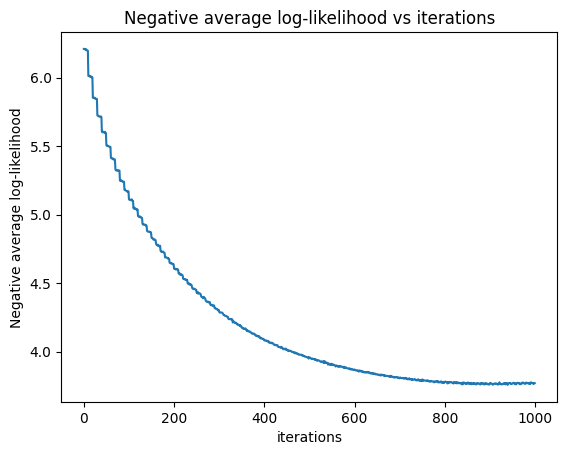

In [168]:
plt.plot(L)
plt.title('Negative average log-likelihood vs iterations')
plt.ylabel('Negative average log-likelihood')
plt.xlabel('iterations')

## Test Results

In [169]:
# likelihood = torch.load('likelihood')
# posterior = torch.load('posterior')
# filter = torch.load('filter')

In [170]:
X_hat, var_posterior = posterior(Y_test)
Y_hat, sig2_eps = likelihood(X_hat)
b, d = filter()
Hk = get_Hk(b, d) # torch.diag((1 + (b**2 / (1 - (d - b)**2))).flatten())
sig2_e = torch.inverse(Hk)

In [171]:
X_hat = X_hat.cpu().detach().numpy()
Y_hat = Y_hat.cpu().detach().numpy()

In [172]:
Xcorr = np.zeros((P, P))
Ycorr = np.zeros((M, M))

for i in range(P):
  for j in range(P):
    Xcorr[i, j] = np.corrcoef(X_test[:, i], X_hat[:, j])[0, -1]

for i in range(M):
  for j in range(M):
    Ycorr[i, j] = np.corrcoef(Y_test.cpu().numpy()[:, i], Y_hat[:, j])[0, -1]

In [173]:
print(Xcorr)

[[-0.47883141  0.33379934  0.20783542]
 [ 0.08015766 -0.50466093 -0.18018293]
 [ 0.54796479 -0.17282226 -0.23119559]]


In [174]:
print(Ycorr)

[[ 0.99879099 -0.27925846 -0.28183552]
 [-0.14497883  0.98662769  0.3619778 ]
 [-0.28823021  0.23827232  0.97443828]]


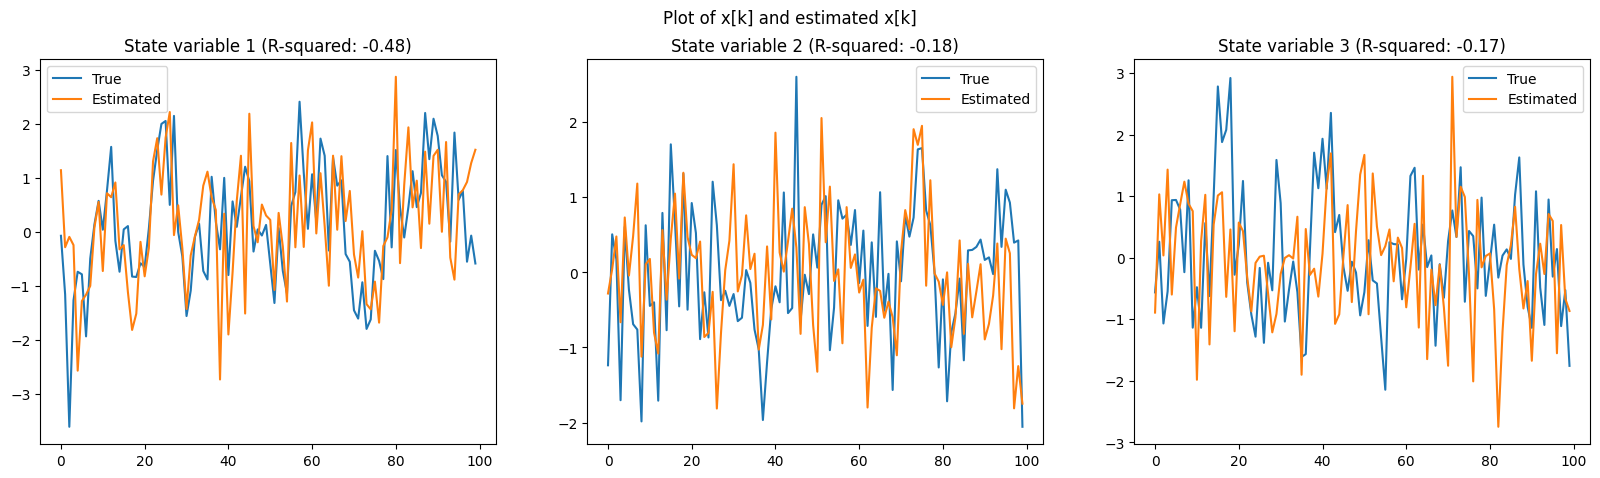

In [179]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].plot(X_test[:100, 0], label = 'True')
ax[0].plot(-X_hat[:100, 0], label = 'Estimated')
ax[0].legend()
ax[0].title.set_text('State variable 1 (R-squared: {})'.format(round(Xcorr[0, 0], 2)))

ax[1].plot(X_test[:100, 1], label = 'True')
ax[1].plot(-X_hat[:100, 1], label = 'Estimated')
ax[1].legend()
ax[1].title.set_text('State variable 2 (R-squared: {})'.format(round(Xcorr[1, 2], 2)))

ax[2].plot(X_test[:100, 2], label = 'True')
ax[2].plot(-X_hat[:100, 2], label = 'Estimated')
ax[2].legend()
ax[2].title.set_text('State variable 3 (R-squared: {})'.format(round(Xcorr[2, 1], 2)))

plt.suptitle('Plot of x[k] and estimated x[k]')

plt.savefig('a.png')

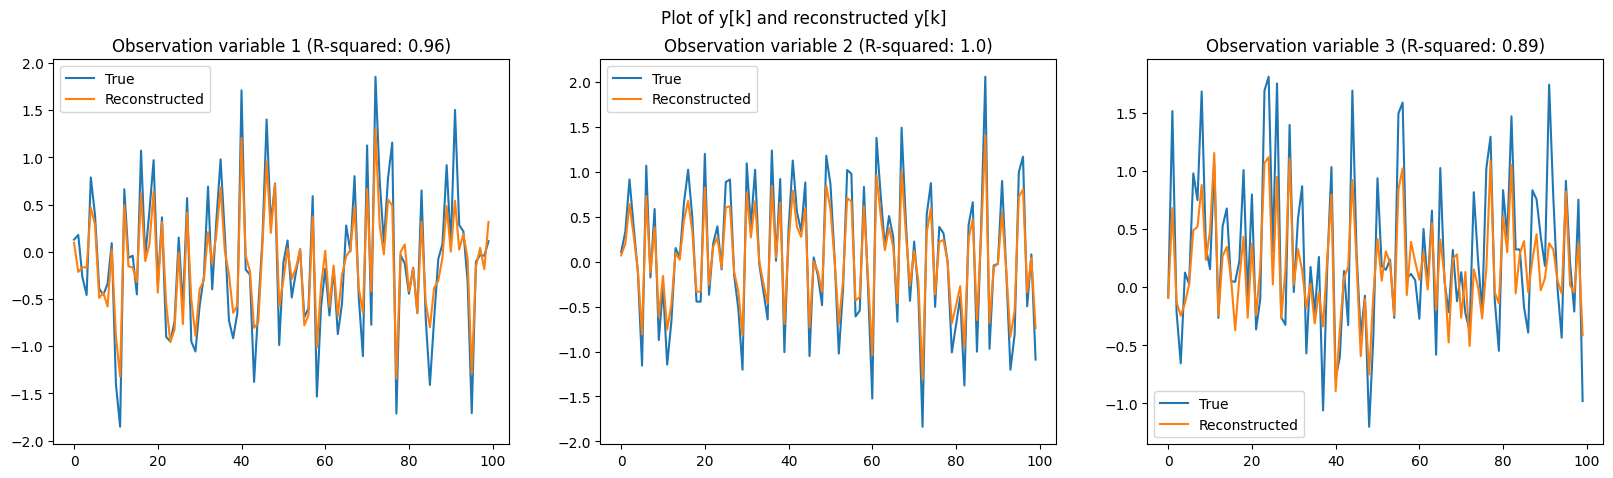

In [141]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].plot(Y_test.cpu().numpy()[:100, 0], label = 'True')
ax[0].plot(Y_hat[:100, 0], label = 'Reconstructed')
ax[0].legend()
ax[0].title.set_text('Observation variable 1 (R-squared: {})'.format(round(Ycorr[0, 0], 2)))

ax[1].plot(Y_test.cpu().numpy()[:100, 1], label = 'True')
ax[1].plot(Y_hat[:100, 1], label = 'Reconstructed')
ax[1].legend()
ax[1].title.set_text('Observation variable 2 (R-squared: {})'.format(round(Ycorr[1, 1], 2)))

ax[2].plot(Y_test.cpu().numpy()[:100, 2], label = 'True')
ax[2].plot(Y_hat[:100, 2], label = 'Reconstructed')
ax[2].legend()
ax[2].title.set_text('Observation variable 3 (R-squared: {})'.format(round(Ycorr[2, 2], 2)))

plt.suptitle('Plot of y[k] and reconstructed y[k]')

plt.savefig('b.png')

In [142]:
sig2_e

tensor([[0.8901, 0.0000, 0.0000],
        [0.0000, 0.9071, 0.0000],
        [0.0000, 0.0000, 0.8154]], device='cuda:0',
       grad_fn=<LinalgInvExBackward0>)

In [143]:
sig2_e0

tensor([[0.8286, 0.0000, 0.0000],
        [0.0000, 0.8612, 0.0000],
        [0.0000, 0.0000, 0.7042]], device='cuda:0',
       grad_fn=<LinalgInvExBackward0>)

In [144]:
b

tensor([[-0.2000],
        [-0.2377],
        [-0.2924]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [145]:
b0

tensor([[-0.1426],
        [-0.2641],
        [-0.3627]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [146]:
d

tensor([[-0.2180],
        [-0.1362],
        [-0.2234]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [147]:
d0

tensor([[-0.3583],
        [-0.1903],
        [-0.2642]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [148]:
sig2_eps

tensor(0.3991, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [149]:
sig2_eps0

tensor(0.4423, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
# torch.save(likelihood0, 'likelihood0')
# torch.save(filter0, 'filter0')

# torch.save(likelihood, 'likelihood')
# torch.save(posterior, 'posterior')
# torch.save(filter, 'filter')

In [ ]:
#@title Default title text
def get_Hk(b, d): ## Change for filter
    return  torch.diag((1 + (b**2 / (1 - (d - b)**2))).flatten())

def get_Ez(M, P, b, d, mu_posterior): ## Change for filter
  N = mu_posterior.shape[0]
  Ez = torch.zeros(N, P).to(device)
  for k in range(N):
    if k:
      Ez.data[k:k+1, :] = d.T*Ez.data[k-1:k, :] + mu_posterior[k:k+1,:] + (b - d).T*mu_posterior[k-1:k, :]
    else:
      Ez.data[k:k+1, :] = torch.ones(1, P).to(device) * mu_posterior[k:k+1,:]
  return Ez

def init_latent_loss(sig2_e, mu_posterior, var_posterior):
  Exx_0 = torch.matmul(mu_posterior[0:1, :].T, mu_posterior[0:1, :]) + var_posterior
  return -0.5 * (torch.trace(torch.matmul(torch.diag(1 / torch.diag(sig2_e)), Exx_0)) + torch.sum(torch.log(torch.diag(sig2_e))))

def latent_loss(N, sig2_e, b, d, Ez, var_posterior):
  lambda_d = 1 + (torch.matmul(b, b.T) / (1 - torch.matmul(d, d.T)))  ## Change for filter
  Ezz = torch.matmul(Ez.T, Ez) + ((N - 1) * var_posterior * lambda_d)
  return -0.5 * (torch.trace(torch.matmul(torch.diag(1 / torch.diag(sig2_e)), Ezz)) + (N - 1)*torch.sum(torch.log(torch.diag(sig2_e))))

def reconstruction_loss(N, M, P, Y, likelihood, mu_posterior, var_posterior, B = 50):
  L = 0
  A = torch.linalg.cholesky(var_posterior)
  for i in range(B):
    X = mu_posterior + torch.matmul(torch.randn((N, P)).to(device), A.T)
    Y_hat, sig2_eps = likelihood(X)
    L += torch.trace(torch.matmul(Y - Y_hat, (Y - Y_hat).T))
  return (-L.squeeze() / (2*B*sig2_eps)) - (0.5*M*N*torch.log(sig2_eps))

def entropy_loss(var_posterior):
  l, _ = torch.linalg.eig(var_posterior)
  return 0.5 * torch.sum(torch.log(l)).real # torch.log(torch.det(var_posterior))

def loss(M, P, Y, posterior, likelihood, filter, B = 50):
  N = Y.shape[0]
  mu_posterior, var_posterior = posterior(Y)
  b, d = filter()
  Hk = get_Hk(b, d) # torch.diag((1 + (b**2 / (1 - (d - b)**2))).flatten()) 
  sig2_e = torch.diag(1 / torch.diag(Hk))
  Ez = get_Ez(M, P, b, d, mu_posterior)
  L = init_latent_loss(sig2_e, mu_posterior, var_posterior)
  L += reconstruction_loss(N, M, P, Y, likelihood, mu_posterior, var_posterior, B = B)
  L += latent_loss(N, sig2_e, b, d, Ez, var_posterior)
  L += N * entropy_loss(var_posterior)
  return -L / N